# 드롭 아웃 & 합성곱 신경망(CNN)

- 오버피팅을 억제하는 방법으로 드롭아웃이라는 기법을 사용할 수 있다. 
  - 뉴런을 임의로 삭제하면서 학습하는 방법이다. 
  - 훈련 때 뉴런을 무작위로 골라 삭제한다. 삭제된 뉴런은 신호를 전달하지 않는다. 훈련 때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달한다. 
  - 단, 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력한다.

In [3]:
import numpy as np

In [4]:
class Dropout : 
    def __init__(self, dropout_ratio=.5):
        self.dropout_ratio = dropout_ratio
        self.mask=None
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else : return x * (1 - self.dropout_ratio)
    def backward(self, dout):
        return dout * self.mask

- 여기에서의 핵심은 훈련 시에는 순전파 때마다 self.mask에 삭제할 뉴런을 False로 표시한다는 것이다. 
- self.mask는 x와 형상이 같은 배열을 무작위로 생성하고, 그 값이 dropout_ratio보다 큰 원소만 True로 설정한다.
- 역전파때의 동작은 ReLU와 같다. 
- 드롭아웃의 효과를 MNIST 데이터셋으로 확인해보자

train loss:2.324100259095491
=== epoch:1, train acc:0.06, test acc:0.0519 ===
train loss:2.3367240344717546
train loss:2.3198828799791507
train loss:2.334138201403393
=== epoch:2, train acc:0.06333333333333334, test acc:0.0534 ===
train loss:2.368374415559161
train loss:2.3381363551504286
train loss:2.3330928399833835
=== epoch:3, train acc:0.06333333333333334, test acc:0.0548 ===
train loss:2.3385353626060423
train loss:2.321698027938764
train loss:2.342470764732769
=== epoch:4, train acc:0.06666666666666667, test acc:0.0566 ===
train loss:2.3181256091192863
train loss:2.318016527906595
train loss:2.3341585909597278
=== epoch:5, train acc:0.07, test acc:0.0585 ===
train loss:2.3223824145629153
train loss:2.3127880613389453
train loss:2.3268800220936066
=== epoch:6, train acc:0.07, test acc:0.0612 ===
train loss:2.3323298965987163
train loss:2.3165949954128062
train loss:2.3143363185934573
=== epoch:7, train acc:0.08333333333333333, test acc:0.0633 ===
train loss:2.315828117487278
trai

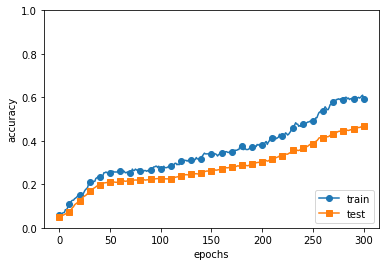

In [5]:
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 그림과 같이 드롭아웃을 적용하니 훈련 데이터와 시험 데이터에 대한 정확도 차이가 줄었다.
- 또, 훈련 데이터에 대한 정확도가 100%에 도달하지도 않게 되었다
  - 즉, 표현력을 높이면서도 오버 피팅을 억제할 수 있다. 
  - 원래는 train의 정확도가 1에 육박하였으며 test와의 정확도 차이도 벌어져 있었다. 

- 기계학습에서의 앙상블 학습은 드롭아웃과 밀접하다. 
  - 드롭아웃이 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델을 학습시키는 것으로 해석할 수 있기 때문이다. 
  - 그리고 추론 때는 뉴런의 출력에 삭제한 비율을 곱함으로써 앙상블 학습에서 여러 모델의 평균을 내는 것과 같은 효과를 얻는 것이다. 
  - 즉 드롭아웃은 앙상블 학습과 같은 효과를 하나의 네트워크로 구현했다고 생각할 수 있다. 

---

- 적절한 하이퍼파라미터 값 찾기
  - 하이퍼파라미터? 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등이다. 
  - 하이퍼 파라미터의 값을 최대한 효율적으로 탐색하는 방법을 설명한다. 

- 검증 데이터 
  - 앞으로 하이퍼파라미터를 다양한 값으로 설정하고 검증할 텐데 여기서 주의할 점은 하이퍼파라미터의 성능을 평가할 때는 시험 데이터를 사용해서 안 된다.
    - 시험 데이터를 사용하여 하이퍼파라미터를 조정하면 하이퍼파라미터 값이 시험 데이터에 오버피팅되기 때문이다.
    - 즉, 하이퍼파라미터 값의 좋음을 시험 데이터로 확인하게 되므로 하이퍼파라미터의 값이 시험 데이터에만 적합하도록 조정되어 버린다. 
    - 그렇게 되면 다른 데이터에는 적응하지 못하니 범용 성능이 떨어지는 모델이 될지도 모른다. 
    - 따라서 하이퍼파라미터를 조정할 때는 하이퍼파라미터 전용 확인 데이터가 필요하다. 이때 검증 데이터라고 부른다. 

- **훈련 데이터** : 매개변수 학습
- **검증 데이터** : 하이퍼파라미터 성능 평가
- **시험 데이터** : 신경망의 범용 성능 평가

- 데이터 셋이 훈련 데이터와 시험 데이터로만 분리되어 있다면 검증 데이터를 직접 분리해주어야 한다. 
- 훈련 데이터 중 20% 정도를 검증 데이터로 먼저 분리하자

```python
def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

(x_train,t_train),(x_test,t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = .2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]
```

- 해당 코드를 통해 훈련 데이터를 분리하기 전에 입력 데이터와 정답 레이블을 뒤섞는다. 데이터 셋 안의 데이터가 치우쳐 있을지도 모르기 때문이다. 

---

- 하이퍼파라미터 최적화
  - 하이퍼파라미터를 최적화할 때의 핵심은 하이퍼파라미터의 최적값이 존재하는 범위를 조금씩 줄여간다는 것이다. 
  - 범위를 조금씩 줄이려면, 우선 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸 후, 그 값으로 정확도를 평가한다. 정확도를 잘 살피면서 이 작업을 여러 번 반복하며 하이퍼파라미터의 최적 값의 범위를 좁혀가는 것이다. 

---

- 정리
  - 이번 장에서는 신경망 학습에 중요한 기술 몇 가지를 소개했다. 매개변수 갱신 방법과 가중치의 초깃값을 설정하는 방법, 또 배치 정규화와 드롭아웃 등 현대적인 신경망에서 빼놓을 수 없는 기술들이다.
    - 매개변수 갱신 방법 : 확률적 경사 하강법(SGD), 모멘텀, AdaGrad,Adam등이 있다. 
    - 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다. 
    - 가충치의 초깃값으로는 Xavier 초깃값과 He 초깃값이 효과적이다.
    - 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값의 영향을 덜 받을 수 있다.
    - 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다. 
    - 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다. 

---

- 합성곱 신경망(Convolutional Neural Network, CNN)
  - 이미지 인식과 음성 인식 등 다양한 곳에서 사용되는데 특히, 이미지 인식 분야에서 딥러닝을 활용한 기법은 거의 다 CNN을 기초로 한다. 
  - 지금까지 본 신경망과 같이 레고 블록처럼 계층을 조합하여 만들 수 있다. 
  - 다만, `합성곱 계층`과 `풀링 계층`이 새롭게 등장한다.
  - 지금까지 본 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있었다. 이를 완전연결, 전결합이라고 하며, 완전히 연결된 계층을 Affine 계층이라는 이름으로 구현했다.
  - 완전 연결 신경망은 Affine 계층 뒤에 활성화 함수를 갖는 ReLU 계층 혹은 Sigmoid 계층이 이어진다. 그렇다면 CNN의 구조는 어떻게 다를까
    - CNN에서는 새로운 합성곱 계층과 풀링 계층이 추가된다.
    - 합성곱 계층 - ReLU - 풀링계층 흐름으로 연결된다. 풀링계층은 생략가능하다.
    - 주의* 출력에 가까운 층은 지금까지의 Affine-ReLU 구성을 사용할 수 있다는 것이다. 또 마지막 출력 계층에선 Affine - Softmax 조합을 그대로 사용한다. 

- CNN에서는 패딩, 스트라이드 등 CNN 고유의 용어가 등장한다. 또, 각 계층 사이에는 3차원 데이터같이 입체적인 데이터가 흐른다는 점에서 완전연결 신경망과 다르다.

- 완전 연결 계층의 문제점
  - 완전연결 계층에서는 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있었다.
  - 그렇다면 문제점은 무엇인가? 데이터의 형상이 무시된다는 것이다. 
    - 만약 입력 데이터가 이미지인 경우를 예로 들면, 이미지는 통상 세로 , 가로, 채널(색상)로 구성된 3차원 데이터이다.
    - 그러나 완전연결 계층에 입력할 때는 3차원 데이터를 평평한 1차원 데이터로 평탄화해줘야 한다. 
    - 완전연결 계층은 형상을 무시하고, 모든 입력 데이터를 동등한 뉴런 즉 같은 차원의 뉴런으로 취급하여 형상에 담긴 정보를 살릴 수 없다. 
    - 한편, 합성곱 계층은 형상을 유지한다. 이미지도 3차원 데이터로 입력받으며, 마찬가지로 다음 계층에도 3차원 데이터로 전달한다. 그래서 CNN에서는 이미지처럼 형상을 가진 데이터를 제대로 이해할 가능성이 있는 것이다. 

- CNN에서는 합성곱 계층의 입출력 데이터를 특징 맵(feature map)이라고도 한다. 
- 합성곱 계층의 입력 데이터를 입력 특징 맵, 출력 데이터를 출력 특징 맵이라고 하는 식이다. 
  - 이 책에서는 입출력 데이터와 특징 맵을 같은 의미로 사용한다. 

- 합성곱 계층에서의 합성곱 연산을 처리하자. 
- 합성곱 연산은 이미지 처리에서 말하는 필터 연산에 해당한다. 필터를 커널이라 칭하기도 한다. 
- 합성곱 연산의 자세한 과정은 교재 231p를 참고한다.

- 완전연결 신경망에는 가중치 매개변수와 편향이 존재하는데, CNN에서는 필터의 매개변수가 그동안의 가중치에 해당한다. 그리고 CNN에도 편향이 존재한다. 
- 편향은 필터를 적용한 후의 데이터에 더해진다. 그리고 편향은 항상 하나만 스칼라로서 존재한다. 그 하나의 값을 필터를 적용한 모든 원소에 더하는 것이다.

- 패딩
  - 합성곱 연산을 수행하기 전에 입력 데이터 주변을 특정 값(예컨대 0)으로 채우기도 한다. 이를 패딩이라한다. 
  - 그렇게되면 출력 데이터의 형상도 달라질 것이다. 
    - 즉 패딩은 주로 출력 크기를 조정할 목적으로 사용한다. 예를 들어(4,4) 입력데이터에 (3,3) 필터를 적용하면 출력은 (2,2)가 되어 입력보다 2만큼 줄어든게 된다. 이는 합성곱 연산을 몇 번이나 되풀이하는 심층 신경망에서는 문제가 될 수 있다. 
    - 합성곱 연산을 거칠 때마다 크기가 작아지면 어느 시점에서는 출력 크기가 1이 되어버린다. 더 이상은 합성곱 연산을 적용할 수 없다는 뜻이다. 이러한 사태를 막기 위해 패딩을 적용한다. 
    - 이를 이용하여 입력 데이터의 공간적 크기를 고정한 채로 다음 계층에 전달할 수 있다. 

- 스트라이드
  - 필터를 적용하는 위치의 간격을 스트라이드라고 한다. 
  - 스트라이드를 2로 하면 필터를 적용하는 윈도우가 두 칸씩 이동한다. 
    - 그렇다면, 스트라이드를 키우면 출력의 크기는 작아진다. 한편, 패딩을 크게하면 출력 크기가 커졌었다. 
    - 이러한 관계를 수식화한 234p를 참고해보자